**Libraries Needed**  
numpy
jieba
gensim
tensorflow
matplotlib
sklearn

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

**Pretrained Word Vectors**  
使用了北京师范大学中文信息处理研究所与中国人民大学 DBIIR 实验室的研究者开源的Chinese-Word-Vectors：  
https://github.com/Embedding/Chinese-Word-Vectors  
word2vec的文章：  
https://zhuanlan.zhihu.com/p/26306795  
我们使用了"chinese-word-vectors"知乎Word+Ngram的词向量，可以从上面github链接下载。

In [2]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('../../sgns.zhihu.bigram',binary=False)

**Word Vectors Model**  
在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量。LSTM并不能直接处理汉字文本，需要先进行分次并把词汇转换为词向量。

In [3]:
# 每一个词都对应一个长度为300的向量
embedding_dim = cn_model['孔子'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
# cn_model['孔子']

词向量的长度为300


In [4]:
# 计算相似度
cn_model.similarity('孔子', '庄子')

0.521646

In [5]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['中国'], topn=10)

[('我国', 0.6130719184875488),
 ('天朝', 0.5357025861740112),
 ('美国', 0.5048182010650635),
 ('中国人', 0.5000995993614197),
 ('本国', 0.4976556897163391),
 ('印度', 0.49548032879829407),
 ('日本', 0.491807758808136),
 ('国内', 0.4640890955924988),
 ('大陆', 0.4627026915550232),
 ('中华民族', 0.43461209535598755)]

In [6]:
# 找出不同的词
test_words = '孔丘 圣人 孔子 孟子 孔子 荀子'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 孔丘 圣人 孔子 孟子 孔子 荀子 中:
不是同一类别的词为: 圣人


In [7]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=10)

[('劈腿', 0.5849199295043945),
 ('婚外情', 0.5557921528816223),
 ('偷情', 0.5555664300918579),
 ('外遇', 0.5458645820617676),
 ('再婚', 0.5422405004501343),
 ('未婚先孕', 0.5357398986816406),
 ('隐婚', 0.5257365703582764),
 ('离婚', 0.524539053440094),
 ('马蓉', 0.5239365696907043),
 ('通奸', 0.5222055912017822)]

In [8]:
# 样本存放于两个文件夹中，分别为正面评价文件夹'pos'和负面评价文件夹'neg'
# 每个文件夹中有txt文件，每个文件中是一例评价
import os
pos_txts = os.listdir('Mental or Casual/mental')
neg_txts = os.listdir('Mental or Casual/casual')

In [9]:
print('样本总共: '+ str(len(pos_txts) + len(neg_txts)))

样本总共: 5492


In [10]:
# 现在我们将所有的评价内容放置到一个list里
train_texts_orig = []
for i in range(len(pos_txts)):
    with open('Mental or Casual/mental/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('Mental or Casual/casual/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
# 添加完所有样本之后，train_texts_orig为一个含有文本的list，其中先是正面评价，后为负面评价

In [34]:
# Verify integrity of original data
len(train_texts_orig)
train_texts_orig[0]

'每天都有干不完的事情，每天九点多十点结束了碎片化和“别人的生活”之后总有种报复性熬夜的快感，喜欢熬夜写稿子，喜欢熬夜读书，喜欢熬夜用安静的整块的时间做一些自己的事。睡不睡觉反而是次要的了。'

In [12]:
# 使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**分词和tokenize**  
首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

In [13]:
# 进行分词和tokenize
# train_tokens是一个长list，其中含有多个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\EdiC\AppData\Local\Temp\jieba.cache
Loading model cost 1.483 seconds.
Prefix dict has been built succesfully.


**索引长度标准化**  
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [14]:
# 获得所有tokens的长度
num_tokens = [len(tokens) for tokens in train_tokens]
num_tokens = np.array(num_tokens)

In [15]:
# 平均tokens的长度
np.mean(num_tokens)

44.825018208302986

In [24]:
# 最长的评价tokens的长度
np.max(num_tokens)
print(num_tokens)

[ 57 194  10 ...   1   6   2]


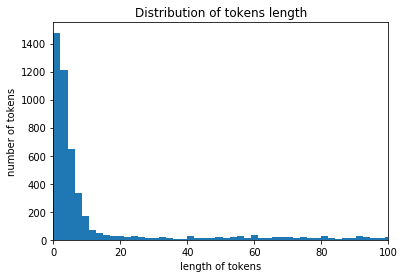

In [33]:
plt.hist(num_tokens,bins=1000)
plt.xlim((0,100))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [35]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

255

In [36]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9608521485797523

**反向tokenize**  
我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [37]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [38]:
reverse = reverse_tokens(train_tokens[9])

In [39]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'同学你好看你的帖子我感受到了你内心对于美好的东西的向往以及看到一些不公平残酷事情时内心的悲伤我知道你是一个很善良的人带着善意去面对生活也希望每一个人都可以被温柔的对待当你不开心时也试着好好关爱一下自己不要把不开心憋闷在心里如果愿意的话可以来跟咨询师聊聊每周四晚八点也可以来在线咨询希望你开心'

In [40]:
# 原始文本
train_texts_orig[9]

'同学你好，看你的帖子我感受到了你内心对于美好的东西的向往，以及看到一些不公平，残酷事情时内心的悲伤。我知道你是一个很善良的人，带着善意去面对生活，也希望每一个人都可以被温柔的对待。当你不开心时，也试着好好关爱一下自己，不要把不开心憋闷在心里，如果愿意的话可以来跟咨询师聊聊，每周四晚八点也可以来在线咨询。希望你开心！'

**准备Embedding Matrix**  
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。  
注意我们只选择使用前100k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [41]:
embedding_dim

300

In [42]:
# 只使用前100000个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 100000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [43]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [44]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(100000, 300)

**padding（填充）和truncating（修剪）**  
我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [45]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [46]:
# 超出五万个词向量的词用0代替
train_pad[train_pad>=num_words] = 0

In [47]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [49]:
# 准备target向量，前1492样本为1，后4000为0
train_target = np.concatenate((np.ones(1492),np.zeros(4000)))

In [50]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [53]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.1, random_state=6)

In [56]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[33]))
print('class: ',y_train[33])

                                                                                                                                                                                                                                                              主人
class:  0.0


现在我们用keras搭建LSTM模型，模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。
keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。   
在Embedding层我们输入的矩阵为：$$(batchsize, maxtokens)$$
输出矩阵为： $$(batchsize, maxtokens, embeddingdim)$$

In [57]:
# implement K-fold validation, k=4
# k = 4
# num_val_samples = len()

In [58]:
# 用LSTM对样本进行分类
model = Sequential()

# 模型第一层为Embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

Instructions for updating:
Colocations handled automatically by placer.


In [59]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

**构建模型**  
我在这个教程中尝试了几种神经网络结构，因为训练样本比较少，所以我们可以尽情尝试，训练过程等待时间并不长：  
**GRU：**如果使用GRU的话，测试样本可以达到87%的准确率，但我测试自己的文本内容时发现，GRU最后一层激活函数的输出都在0.5左右，说明模型的判断不是很明确，信心比较低，而且经过测试发现模型对于否定句的判断有时会失误，我们期望对于负面样本输出接近0，正面样本接近1而不是都徘徊于0.5之间。  
**BiLSTM：**测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，这可能是因为BiLSTM对于比较长的句子结构有更好的记忆，有兴趣的朋友可以深入研究一下。  
Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果。

In [60]:
# GRU的代码
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [61]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

In [62]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [63]:
# 模型的结构
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 255, 300)          30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 255, 64)           85248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 30,090,449
Trainable params: 90,449
Non-trainable params: 30,000,000
_________________________________________________________________


In [64]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [65]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [66]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [67]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [68]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [69]:
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 4447 samples, validate on 495 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
4352/4447 [============================>.] - ETA: 1s - loss: 0.2415 - acc: 0.9331
Epoch 00001: val_loss improved from inf to 0.08438, saving model to sentiment_checkpoint.keras
4447/4447 [==============================] - 62s 14ms/sample - loss: 0.2385 - acc: 0.9341 - val_loss: 0.0844 - val_acc: 0.9859
Epoch 2/20
4352/4447 [============================>.] - ETA: 1s - loss: 0.0748 - acc: 0.9837
Epoch 00002: val_loss improved from 0.08438 to 0.05289, saving model to sentiment_checkpoint.keras
4447/4447 [==============================] - 57s 13ms/sample - loss: 0.0752 - acc: 0.9834 - val_loss: 0.0529 - val_acc: 0.9859
Epoch 3/20
4352/4447 [============================>.] - ETA: 1s - loss: 0.0518 - acc: 0.9878
Epoch 00003: val_loss improved from 0.05289 to 0.03587, saving model to sentiment_checkpoint.keras
4447/4447 [==============================] - 58s 13ms/sample - loss: 0.0529 - a

**结论**  
我们首先对测试样本进行预测，得到了还算满意的准确度。  
之后我们定义一个预测函数，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [70]:
result = model.evaluate(X_test, y_test)
print('Accuracy:'+str(result[1]))

550/550 [==============================] - 3s 6ms/sample - loss: 0.0172 - acc: 0.9964
Accuracy:0.99636364


In [71]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是心理相关的','output=%.2f'%coef)
    else:
        print('是相对闲聊的','output=%.2f'%coef)

In [97]:
test_list = [
    '再接再厉，相同行为背后的原因是不一样的，再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的',
    '你好',
    '你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好',
    '我的心情有时候好，有时候不好',
    '我很孤独',
    '陈子迅',
    '再接再厉，相同行为背后的原因是不一样的',
    '同学你好',
    '同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好'
]
for text in test_list:
    predict_sentiment(text)

再接再厉，相同行为背后的原因是不一样的，再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的
是心理相关的 output=0.99
你好
是相对闲聊的 output=0.00
你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好你好
是心理相关的 output=0.92
我的心情有时候好，有时候不好
是相对闲聊的 output=0.34
我很孤独
是相对闲聊的 output=0.01
陈子迅
是相对闲聊的 output=0.01
再接再厉，相同行为背后的原因是不一样的
是相对闲聊的 output=0.02
同学你好
是相对闲聊的 output=0.00
同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好同学你好
是心理相关的 output=0.99


##### **错误分类的文本**
经过查看，发现错误分类的文本的含义大多比较含糊，就算人类也不容易判断极性。

In [90]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [91]:
y_actual = np.array(y_test)

In [92]:
# 找出错误分类的索引
misclassified = np.where(y_pred != y_actual)[0]

In [93]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

99


In [94]:
# 找出错误分类的样本
idx=3
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

           选诚恳的人
预测的分类 1
实际的分类 1.0


In [95]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

            氪金打游戏
预测的分类 1
实际的分类 0.0
